In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [2]:
stock = pd.read_csv('SH601688.csv')
dates = pd.read_excel('dates.xlsx',index_col=0).drop('Unnamed: 2',axis=1)
data = pd.concat([dates, stock['Close']], axis=1)
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']
data.drop(['Date'], axis=1, inplace=True)
data

,Close
Date,
2018-01-01,22.4050
2018-01-02,22.5605
2018-01-03,22.6049
2018-01-04,22.4161
2018-01-05,22.2496
...,...
2020-11-17,22.8111
2020-11-18,22.2461
2020-11-19,22.6463


In [3]:
dataset = data.values
training = dataset[:504,:]
valid = dataset[504:,:]

split = int(0.7*len(training))
train = training[:split]
test = training[split:]

In [10]:
756-152-252

352

In [3]:
dataset = data.values
training = dataset[:504,:]
valid = dataset[504:,:]

split = int(0.7*len(training))
train = training[:split]
test = training[split:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

inW, outW = 252, 4
x_train, y_train = [], []
for i in range(inW,len(train),outW):
    x_train.append(scaled_data[i-inW:i,0])
    y_train.append(scaled_data[i:i+outW,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=200))
model.add(Dense(outW))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

inputs = data[len(data) - len(test) - inW:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(inW,inputs.shape[0],outW):
    X_test.append(inputs[i-inW:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price.reshape(-1,1)[:len(test)]
rms = np.sqrt(np.mean(np.power((test-closing_price),2)))
rms

Epoch 1/1
 - 11s - loss: 0.0279


4.342470670194103

C:\Users\rajat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


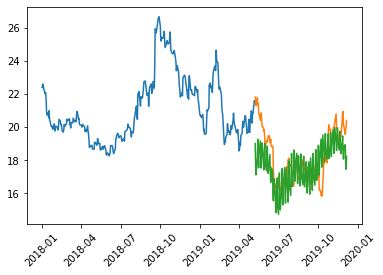

In [4]:
train = data[:split]
test = data[split:len(training)]
valid = data[len(training):]
test['Predictions'] = closing_price
fig = plt.figure()
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.xticks(rotation=45)
plt.show()
# fig.savefig('train1.png')